Created: 15-07-2022, Last-Updated: 17-07-2022
# Stochastic models and optimization - Bandits - Problem set 2
Student: Philine Meyjohann

In [1]:
# import relevant packages
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15, 8)

random.seed(42)

## Gaussian processes
This problem focuses on Gaussian processes that is most often used as a function learning component
of Bayesian optimization algorithm. It is also a powerful supervised learning algorithm that will be an
important addition in your machine learning toolbox.

Your task will be to reproduce Figure 2.5 (and Figure 2.2-a) from Rasmussen & Willams (2006) book,
by implementing their Algorithm 2.1.

In these illustrations the authors are using a GP with zero mean function and squared exponential (SE)
kernel. In addition they assume noisy observations.

+ First, code up the SE kernel and draw some sample functions based on a GP with SE and using SE parameters from Figure 2.5-a $((l, \sigma_f, \sigma_n) = (1, 1, 0.1))$. These are draws from the prior, before observing any training data. For test points use 100 equidistant points on $(−7, 7)$ interval. You should obtain a figure similar to Figure 2.2-a. Connect the points so they form a line. Illustrate the shaded region as well, two times the standard deviation of the prior.
+ Next, instead of implementing GP inference directly through conditioning equations, you will implement the Algorithm 2.1. Note that when doing Cholesky decomposition you need to add some very small number $\epsilon$  to the diagonal of the covariance matrix, for numerical stability.
+ Then you will produce some training data. Draw 20 training points randomly from $U(−7, 7)$ and compute their function values by taking a single draw from the prior for these points.
+ Finally, you are ready to reproduce posterior plots from Figure 2.5. Use the data from the previous step and produce predictions for 100 equidistant points on $(−7, 7)$ interval, same as for illustration of the prior. As in 2.5-a use $(l, \sigma_f, \sigma_n) = (1, 1, 0.1)$ when computing the covariance function, while in 2.5-b and 2.5-c you should use $(l, \sigma_f, \sigma_n) = (0.3, 1.08, 0.00005)$ and $(l, \sigma_f, \sigma_n) = (3, 1.16, 0.89)$ respectively. Connect the points so they form a line. Illustrate the shaded region as well, two times the standard deviation of the posterior.

### Code SE kernel and draw some example functions

In [2]:
def SE_kernel(X1, X2, l=1, sigma_f=1):
    K = np.zeros([len(X1), len(X2)])
    for p in range(0,len(X1)):
        for q in range(0,len(X2)):
            K[p][q] = sigma_f**2 * np.exp(-0.5*((np.absolute(X1[p] - X2[q]))**2)/(l**2))
    return K

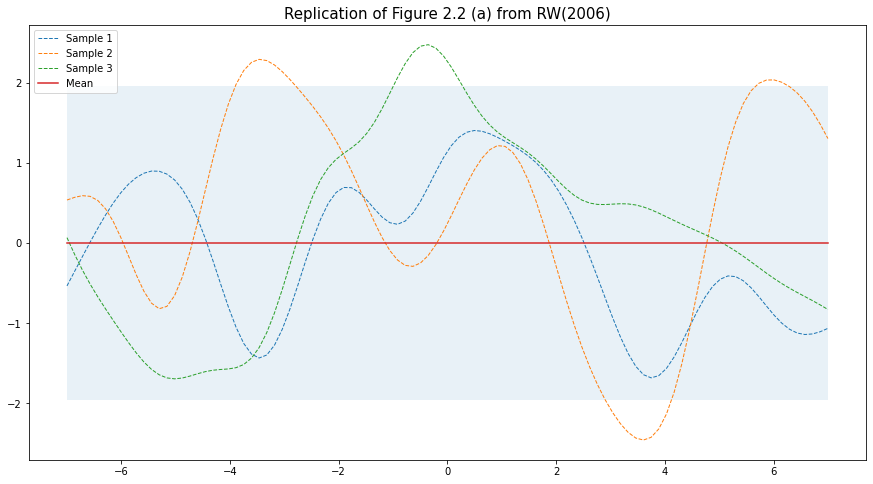

In [3]:
# finite number of points
x_test = np.linspace(-7, 7, 100)

# mean and covriance of the prior
mean = np.zeros(x_test.shape)
cov = SE_kernel(x_test, x_test)

# draw three samples from the prior
samples = np.random.multivariate_normal(mean, cov, 3)

# Plot GP mean, uncertainty region and samples 
sd = np.sqrt(np.diag(cov))

for i, sample in enumerate(samples):
    plt.plot(x_test, sample, lw=1, ls='--', label=f'Sample {i+1}')
plt.fill_between(x_test, mean + 1.96*sd, mean - 1.96*sd, alpha=0.1)
plt.plot(x_test, mean, label='Mean')
plt.title("Replication of Figure 2.2 (a) from RW(2006)", fontsize=15)
plt.legend();

### Implement Algorithm 2.1

I replicate Algorithm 2.1 as specified in Rasmussen and Williams (2006):
<div>
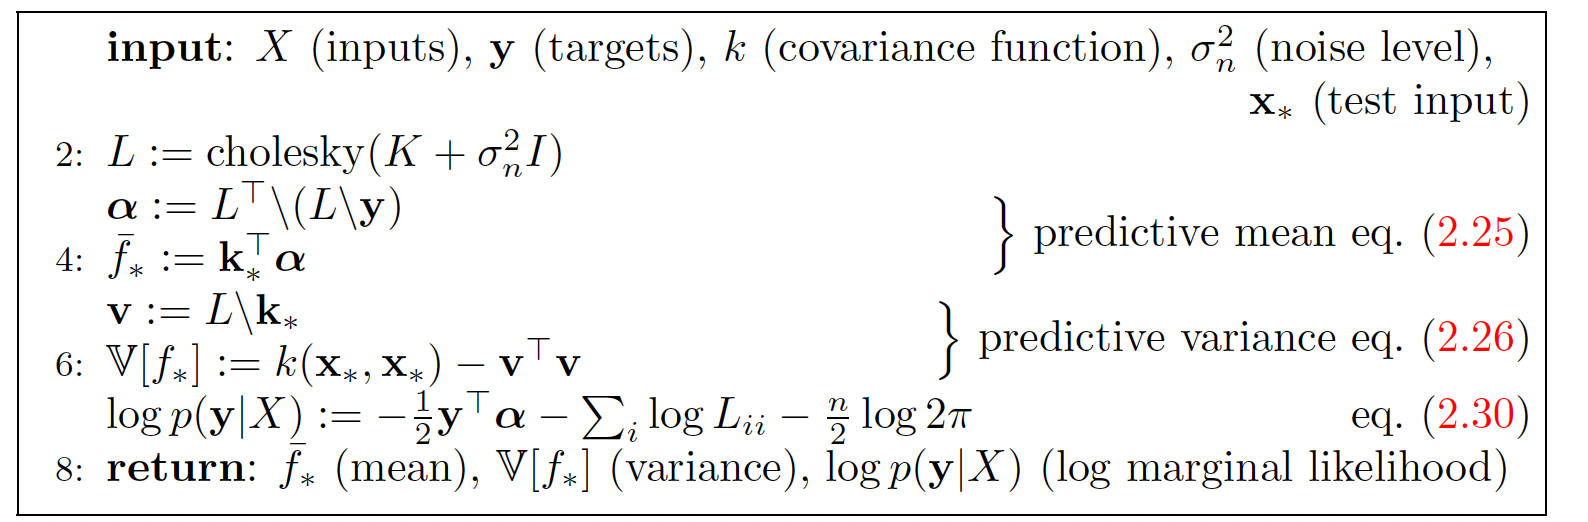
</div>

In [4]:
# Original based on Ben
def algorithm_2_1(y, X, x_test, epsilon, l=1, sigma_f=1, sigma_n=0.1):
    
    """Algorithm 2.1
    
    Predictions and log marginal likelihood for Gaussian process regression.
    (Replicates alogrithm 2.1 from RW(2006))
    
    Parameters
    ----------
    X : training input
    x_test : testing input
    epsilon : noise for numerical stability in the Cholesky decomposition
    kernel : kernel / covariance function
    l : length-scale factor which varies the width of the distribution
    sigma_f : cale factor which dictates how far from the mean we can deviate
    sigma_n : variance of the idd noise
        
    Returns
    -------
    y : function values
    f_bar_star : mean of predictive distribution
    Var_f_star : variance of predictive distribution
    """
    cov_prior = SE_kernel(X, X, l, sigma_f) # generate covariance matrix
    
    # compute function values by taking a single draw from the prior
    L = np.linalg.cholesky(cov_prior + np.eye(len(X))*sigma_n**2)
    
    # predictive mean eq. 
    alpha = np.linalg.solve(L.T, np.linalg.solve(L,y))
    k_star = SE_kernel(X, x_test, l, sigma_f) # covariance matrix between train and test points
    f_bar_star = np.dot(k_star.T, alpha) # compute mean of predictive distribution
    
    # predictive variance eq.
    v = np.linalg.solve(L, k_star)
    Var_f_star = SE_kernel(x_test, x_test, l, sigma_f) - np.dot(v.T, v) # compute variance of predictive distribution
    Var_f_star = Var_f_star + (sigma_n**2)*np.eye(len(x_test))

    return y, f_bar_star, Var_f_star

In [5]:
# produce training data - 20 points randomly from U(-7,7)
X = np.random.uniform(-7, 7, 20)

# generate function values for training data
mean = np.zeros((len(X)))
cov_prior = SE_kernel(X, X)
y = np.random.multivariate_normal(mean, cov_prior)

# set combinations of parameters for the three plots
params0 = {'l': 1, 'sigma_f': 1, 'sigma_n': 0.1}
params1 = {'l': 0.3, 'sigma_f': 1.08, 'sigma_n': 0.00005}
params2 = {'l': 3, 'sigma_f': 1.16, 'sigma_n': 0.89}
parameters = [params0, params1, params2]

# define epsilon
epsilon = 1e-10

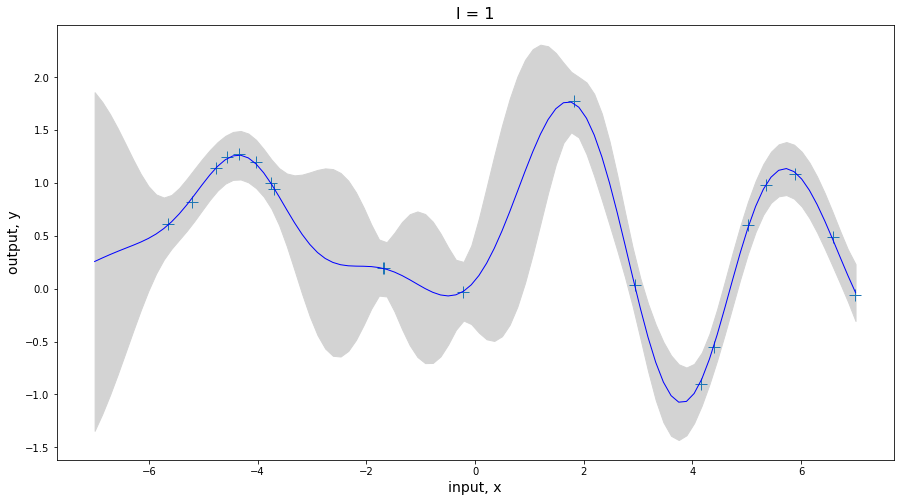

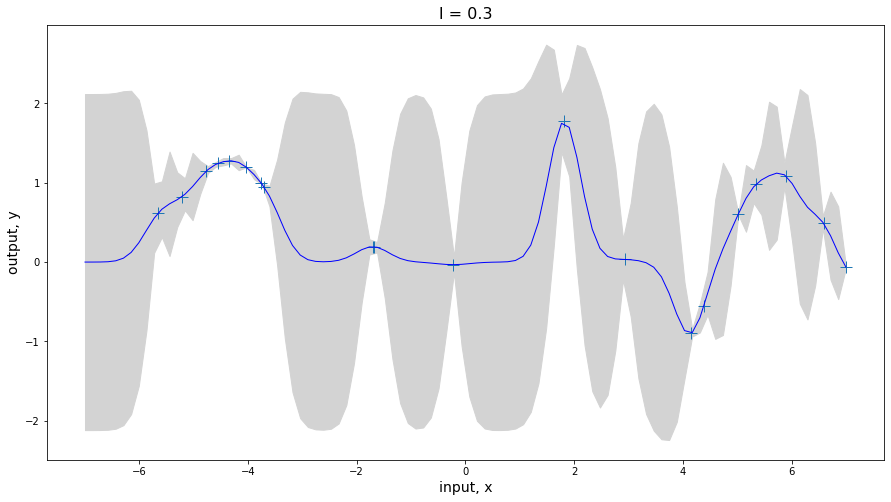

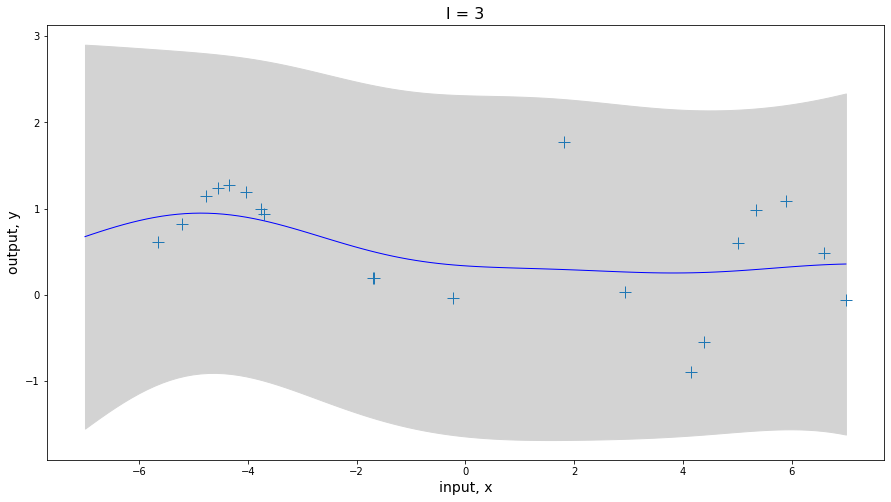

In [6]:
# iterate over different parameters
for param in parameters:
    
    # run algorithm 2.1
    function_values, pred_mean, pred_var = algorithm_2_1(y, X, x_test, epsilon,
                                           param['l'], param['sigma_f'], param['sigma_n'])
    
    # calculate standard deviation
    sd = np.sqrt((np.diagonal(pred_var)))

    # plot results
    plt.plot(X, function_values, '+', ms=12)
    plt.gca().fill_between(x_test, pred_mean-1.96*sd, pred_mean+1.96*sd, color="lightgray")
    plt.plot(x_test, pred_mean, 'b-', lw=1)
    plt.xlabel('input, x', fontsize = 14)
    plt.ylabel('output, y', fontsize = 14)
    plt.title('l = '+ str(param['l']), fontsize = 16)
    plt.show();


## Bayesian optimization
This problem focuses on implementing a few basic Bayesian optimization algorithms on one of the benchmark functions widely used in the literature.

The function that will pose as “an objective function very expensive to evaluate” is Branin or Branin-Hoo function. It’s a 2-dimensional function which has somewhat challenging surface consisting of three global
minima. You can think of this as if you had a big neural network model with two hyperparameters, which takes a long time to train.

More precisely, the objective function has the following form:

$$f(x) = a(x_2-bx_1^2 + cx_1-r)^2 + s(1-t)\cos(x_1)+s$$

where parameter values are: $a = 1$, $b = 5.1/(4\pi^2)$, $c = 5/\pi$ , $r = 6$, $s = 10$ and $t = 1/(8\pi)$ (though some papers do change these parameters sometimes). The function should be evaluated on the
square $x_1 \in [−5, 10]$ and $x_2 \in [0, 15]$. The global min is $f(x^{star}) = 0.397887$ at following three points: $x^{star} = (−\pi, 12.275), (\pi, 2.275), (9.42478, 2.475)$. Note that the objective here will be to find a min of the function, not the max.

You will implement three Bayesian optimization algorithms: GP combined with UCB, EI and PI
acquisition functions. For GP part you can use your own code developed in the first exercise, with
squared exponential kernel, or one of the popular libraries (e.g. GPflow). You should optimize
hyperparameters in every iteration, after you observe a function value add a new point to the training
data. If you use your own implementation, you will need to code that part up as well. No need to do
something sophisticated here, you can use the maximum likelihood approach and optimize the marginal
likelihood, and you can use for example a gradient free simplex method to optimize it. For optimizing
the acquisition functions you can use a simple approach of discretising the 2-dimensional space in a fine
grid of points.

Start the algorithms with five randomly chosen points from the Branin functions. Optimize hyperparameters
of the GP on these points, make predictions and optimize acquisition function to make a
choice for the next point to sample. Do this iteratively until 100 points are observed. Repeat this for
all three acquisition functions along with 3 different values of their exploration parameters. You should
produce a figure (or several figures) that compares performance of these 9 acquisition function, with
iterations on x-axis and squared error between achieved value in that iteration and true max on y-axis.

### Notes
Nomenclature:
- Surrogate model: Bayesian approximation of the objective function that can be sampled efficiently.
- Acquisition funtion: Technique by which the posterior is used to select the next sample from the search space.

The Bayesian Optimization algorithm can be summarized as follows:
1. Select a Sample by Optimizing the Acquisition Function.
2. Evaluate the Sample With the Objective Function.
3. Update the Data and, in turn, the Surrogate Function.
4. Go To 1.


Inspiration was taken from the following sources:
+ https://towardsdatascience.com/bayesian-optimization-a-step-by-step-approach-a1cb678dd2ec
+ https://machinelearningmastery.com/what-is-bayesian-optimization/

### Define Bayesian Optimizer class

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.stats as scis 
from tqdm import tqdm

In [8]:
class BayesianOptimizer():
    def __init__(self, X, y, target_func, acq_func, expl_params, n_iter):
        self.X = X
        self.y = y
        self.target_func = target_func
        self.initial_params = [1, 1, 0.1] # l, sigma_f, sigma_n
        self.opt_params = self.initial_params
        self.acq_func = acq_func # choice of ["exp_imp", "prob_imp", "ucb"]
        self.expl_params = expl_params
        self.n_iter = n_iter
     
    
    ## Set-up
    # define a the squared exponential kernel function for a 2-D input 
    def _SE_kernel(self, X1, X2, params):
        """ Covariance matrix.
        
        Iteratively applies the squared exponential covariance function to all points in the two input arrays.
        
        Inputs:
        -------
        X1 and X2 : two input vectors
        params : hyperparameters
            - sigma_f : scale factor which dictates how far from the mean we can deviate
            - length : length-scale factor which varies the width of the distribution

        Returns:
        --------
        K : covariance matrix i.e. similarity between all points in X1 and X2
        """
    
        K = np.zeros([len(X1), len(X2)])
        for p in range(0,len(X1)):
            for q in range(0,len(X2)):
                K[p, q] = params[1]**2 * np.exp(-(1/(2*(params[0]**2)))*(np.dot(X1[p].T,X1[p]) + np.dot(X2[q].T,X2[q]) - 2 * np.dot(X1[p].T,X2[q])))
        return K
    
    
    # define surrogate model (Gaussian process)
    def _algorithm_2_1(self, X_test):
        cov_prior = self._SE_kernel(self.X, self.X, self.opt_params) # generate covariance matrix

        # compute function values by taking a single draw from the prior
        L = np.linalg.cholesky(cov_prior + np.eye(len(self.X))*self.opt_params[2]**2 + np.eye(len(self.X))**1e-4)

        # predictive mean eq. 
        alpha = np.linalg.solve(L.T, np.linalg.solve(L,self.y))
        k_star = self._SE_kernel(self.X, X_test, self.opt_params) # covariance matrix between train and test points
        f_bar_star = np.dot(k_star.T, alpha) # compute mean of predictive distribution

        # predictive variance eq.
        v = np.linalg.solve(L, k_star)
        Var_f_star = self._SE_kernel(X_test, X_test, self.opt_params) - np.dot(v.T, v) # compute variance of predictive distribution
        Var_f_star = Var_f_star + (self.opt_params[2]**2)*np.eye(len(X_test))

        return f_bar_star, Var_f_star
       
         
    # draw random sample of points
    def _random_sample(self, sample_size=2**8):
        sample_x1 = np.random.uniform(-5, 10, sample_size)
        sample_x2 = np.random.uniform(0, 15, sample_size)
        X_new = np.column_stack([sample_x1, sample_x2])
        return X_new
      
    
    ## define acquisition functions
    # Upper confidence bound
    def _get_upper_confidence_bound(self, expl_param):
        sample = self._random_sample()
        pred, var = self._algorithm_2_1(sample)
        sigma = np.sqrt(np.diagonal(var))
        ucb = pred - expl_param*sigma # minus because we minimising
        best = np.argmin(ucb)
        return sample[best].reshape(-1, 2) # returns next sample
    
    # Expected Improvement
    def _get_expected_improvement(self, expl_param):
        sample = self._random_sample()
        pred, var = self._algorithm_2_1(sample)
        sigma = np.sqrt(np.diagonal(var))
        Z = (pred-np.min(self.y)-expl_param)/sigma
        exp_imp = (pred-np.min(self.y)-expl_param)*scis.norm.cdf(Z)+sigma*scis.norm.pdf(Z)
        best = np.argmin(exp_imp)
        return sample[best].reshape(-1, 2) # returns next sample
    
    # Probability Improvement
    def _get_probability_improvement(self, expl_param):
        sample = self._random_sample()
        pred, var = self._algorithm_2_1(sample)
        sigma = np.sqrt(np.diagonal(var))
        prob_imp = scis.norm.cdf((pred-np.min(self.y)-expl_param)/sigma)
        best = np.argmin(prob_imp)
        return sample[best].reshape(-1, 2) # returns next sample
    
    
    # select sample by optimizing acquisition function
    def _get_next_probable_point(self, expl_param):
        if self.acq_func == "exp_imp":
            return self._get_expected_improvement(expl_param)
        elif self.acq_func == "prob_imp":
            return self._get_probability_improvement(expl_param)
        elif self.acq_func == "ucb":
            return self._get_upper_confidence_bound(expl_param)
    
    
    ## optimize hyperparameters
    def _marginal_likelihood(self, params):
        params = self.opt_params
        cov_matrix_prior = self.cov_matrix(self.X, self.X) 
        L = np.linalg.cholesky(cov_matrix_prior + np.eye(len(self.X))*parameters[2]**2) # + np.eye(len(self.X))*1e-4) (to add noise)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, self.y)) 
        mll = -0.5*np.dot(self.y.T, alpha) - np.sum(np.log(np.diagonal(L))) - (len(self.X)/2)*np.log(2*np.pi)
        return -mll 

    def _optimize_hyperparameters(self):
        opt = minimize(self._marginal_likelihood, x0 = self.opt_params, method = 'Nelder-Mead',
                       options={"maxfev": 1e-5, "fatol": 1e-2, "xatol": 1e-2})
        self.opt_params[0] = opt.x[0]
        self.opt_params[1] = opt.x[1]
        self.opt_params[2] = opt.x[2]
        return self.opt_params
    
    
    # update the data
    def _extend_prior_with_posterior_data(self, X_next, y_next):
        self.X = np.vstack((self.X, X_next))
        self.y = np.append(self.y, y_next)
      
    
    
    ## optimize using Gaussian process regressor as surrogate 
    def optimize(self):
        # find minimum and corresponding parameter x from initial "prior" datapoints
        y_min = np.min(self.y)
        y_min_ind = np.argmin(self.y)
        optimal_X = self.X[y_min_ind]
        
        # initialise surrogate function
        pred, var = self._algorithm_2_1(self.X)
        
        # to save results
        optimal_X_results = {}
        y_min_results = {}

        for expl_param in self.expl_params:
            for i in tqdm(range(self.n_iter)):
                ## 1) Select a Sample by Optimizing the Acquisition Function.
                # get next best parameter x using acquisition function
                X_next = self._get_next_probable_point(expl_param)

                ## 2) Evaluate the Sample With the Objective Function.
                # get the y-value for that parameter using the target function = "posterior" data point
                y_next = self.target_func(X_next[:,0], X_next[:,1])
                
                # optimize hyperparameters
                opt_hyperparam = self._optimize_hyperparameters

                ## 3) Update the Data and, in turn, the Surrogate Function.
                self._extend_prior_with_posterior_data(X_next,y_next)
                pred, var = self._algorithm_2_1(self.X)

                # return minimum "y" value and corresponding parameter x
                if y_next[0] < y_min:
                    y_min = y_next
                    optimal_X = X_next
                    
                name = 'exploration_parameter_' + str(expl_param)
                optimal_X_results[name] = optimal_X
                y_min_results[name] = y_min

        return optimal_X_results, y_min_results

In [9]:
TRUE_MIN = 0.397887

In [10]:
# define costly function
def Branin_Hoo(x1, x2, a=1, b=5.1/(4*np.pi**2), c=5/np.pi, r=6, s=10, t=1/(8*np.pi)):
    f = a*(x2-b*x1**2+c*x1-r)**2+s*(1-t)*np.cos(x1)+s
    return f

In [11]:
x1 = np.random.uniform(-5, 10, 5)
x2 = np.random.uniform(0, 15, 5)
X = np.column_stack((x1,x2))
y = Branin_Hoo(X[:,0], X[:,1])

exploration_parameters = [0.001, 0.01, 1]

In [12]:
# see if Branin Hoo function works correctly
round(TRUE_MIN, 5) == round(Branin_Hoo(-np.pi,12.275),5) == round(Branin_Hoo(np.pi,2.275),5) == round(Branin_Hoo(9.42478,2.475),5)

True

### Run Bayesian Optimization algorithm

In [13]:
# results UCB
bopt = BayesianOptimizer(X, y, Branin_Hoo, "ucb", exploration_parameters, 95)
optimal_X_ucb, y_min_ucb = bopt.optimize()

100%|███████████████████████████████████████████| 95/95 [02:52<00:00,  1.81s/it]


In [23]:
optimal_X_ucb

{'exploration_parameter_0.001': array([[9.43014378, 2.46352315]]),
 'exploration_parameter_0.01': array([[9.43014378, 2.46352315]]),
 'exploration_parameter_1': array([[9.43014378, 2.46352315]])}

In [24]:
y_min_ucb

{'exploration_parameter_0.001': array([0.39828181]),
 'exploration_parameter_0.01': array([0.39828181]),
 'exploration_parameter_1': array([0.39828181])}

In [17]:
# results Expected Improvement
bopt = BayesianOptimizer(X, y, Branin_Hoo, "exp_imp", exploration_parameters, 95)
optimal_X_exp_imp, y_min_exp_imp = bopt.optimize()

100%|███████████████████████████████████████████| 95/95 [02:54<00:00,  1.83s/it]


In [25]:
optimal_X_exp_imp

{'exploration_parameter_0.001': array([[9.47372476, 2.5379956 ]]),
 'exploration_parameter_0.01': array([[9.40603381, 2.49794994]]),
 'exploration_parameter_1': array([[9.40603381, 2.49794994]])}

In [26]:
y_min_exp_imp

{'exploration_parameter_0.001': array([0.40984527]),
 'exploration_parameter_0.01': array([0.40107303]),
 'exploration_parameter_1': array([0.40107303])}

In [18]:
# results Probability Improvement
bopt = BayesianOptimizer(X, y, Branin_Hoo, "prob_imp", exploration_parameters, 95)
optimal_X_prob_imp, y_min_prob_imp = bopt.optimize()

100%|███████████████████████████████████████████| 95/95 [02:44<00:00,  1.73s/it]


In [27]:
optimal_X_prob_imp

{'exploration_parameter_0.001': array([[9.38563373, 2.4273206 ]]),
 'exploration_parameter_0.01': array([[9.38563373, 2.4273206 ]]),
 'exploration_parameter_1': array([[9.42432693, 2.47097817]])}

In [28]:
y_min_prob_imp

{'exploration_parameter_0.001': array([0.40546371]),
 'exploration_parameter_0.01': array([0.40546371]),
 'exploration_parameter_1': array([0.39790159])}

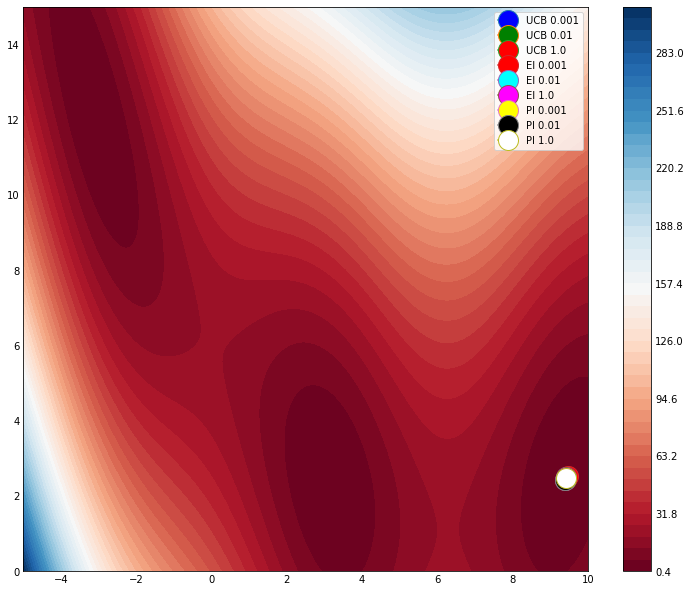

In [19]:
plt.style.use('_mpl-gallery-nogrid')

# make data for contourplot
X1, X2 = np.meshgrid(np.linspace(-5, 10,1000), np.linspace(0, 15,1000))
Y = Branin_Hoo(X1,X2)
levels = np.linspace(Y.min(), Y.max(), 50)

# plot
fig, ax = plt.subplots(figsize=(10,8))
cp=ax.contourf(X1, X2, Y, levels=levels,cmap='RdBu')
fig.colorbar(cp)
plt.plot(optimal_X_ucb['exploration_parameter_0.001'][:,0], optimal_X_ucb['exploration_parameter_0.001'][:,1], marker="o", markersize=20, markerfacecolor="blue",label="UCB 0.001")
plt.plot(optimal_X_ucb['exploration_parameter_0.01'][:,0], optimal_X_ucb['exploration_parameter_0.01'][:,1], marker="o", markersize=20, markerfacecolor="green",label="UCB 0.01")
plt.plot(optimal_X_ucb['exploration_parameter_1'][:,0], optimal_X_ucb['exploration_parameter_1'][:,1], marker="o", markersize=20, markerfacecolor="red",label="UCB 1.0")
plt.plot(optimal_X_exp_imp['exploration_parameter_0.001'][:,0], optimal_X_exp_imp['exploration_parameter_0.001'][:,1], marker="o", markersize=20, markerfacecolor="red",label="EI 0.001")
plt.plot(optimal_X_exp_imp['exploration_parameter_0.01'][:,0], optimal_X_exp_imp['exploration_parameter_0.01'][:,1], marker="o", markersize=20, markerfacecolor="cyan",label="EI 0.01")
plt.plot(optimal_X_exp_imp['exploration_parameter_1'][:,0], optimal_X_exp_imp['exploration_parameter_1'][:,1], marker="o", markersize=20, markerfacecolor="magenta",label="EI 1.0")
plt.plot(optimal_X_prob_imp['exploration_parameter_0.001'][:,0], optimal_X_prob_imp['exploration_parameter_0.001'][:,1], marker="o", markersize=20, markerfacecolor="yellow",label="PI 0.001")
plt.plot(optimal_X_prob_imp['exploration_parameter_0.01'][:,0], optimal_X_prob_imp['exploration_parameter_0.01'][:,1], marker="o", markersize=20, markerfacecolor="black",label="PI 0.01")
plt.plot(optimal_X_prob_imp['exploration_parameter_1'][:,0], optimal_X_prob_imp['exploration_parameter_1'][:,1], marker="o", markersize=20, markerfacecolor="white",label="PI 1.0")
plt.legend()
plt.show()

Unfortunately, I encountered some difficulties in coding the Bayesian Optimizer. It took me a long time to figure it out and I did not have enough time to calculate and plot the squared error. Looking at the contour plot however, we see that my algorithm seems to work. All points collect at one of the three global minima.